In [63]:
%pip install ipdb

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [64]:
%pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [131]:
import os
from argparse import Namespace
import json

import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2

from train import main
from utils import ThousandLandmarksDataset, ScaleMinSideToSize, CropCenter, TransformByKeys, TransformByKeysA
from torchvision import transforms # можно использовать albumentations.Compose или torchvision.transforms.Compose

In [132]:
augmentation_lst = [
#     ('RandomBrightnessContrast', TransformByKeysA(A.RandomBrightnessContrast(always_apply=False, p=0.2, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), brightness_by_max=True), ("image",))),
#     ('RandomGamma', TransformByKeysA(A.RandomGamma(always_apply=False, p=0.2, gamma_limit=(30, 140), eps=1e-07), ("image",)),),
#     ('ToGray', TransformByKeysA(A.ToGray(always_apply=False, p=0.2), ("image",))),
#     ('Blur', TransformByKeysA(A.Blur(always_apply=False, p=0.2, blur_limit=(3, 7)), ("image",))),
#     ('GaussNoise', TransformByKeysA(A.GaussNoise(always_apply=False, p=0.2, var_limit=(50.0, 70.0)), ("image",))),
#     ('CoarseDropout', TransformByKeysA(A.CoarseDropout(always_apply=False, p=0.2, max_holes=1, max_height=50, max_width=50, min_holes=1, min_height=50, min_width=50), ("image",))),
    ('ToGray_transforms', TransformByKeys(transforms.RandomGrayscale(p=0.2), ("image",))),
]

In [133]:
#!g1.1

CROP = 256

for agm in augmentation_lst:
    
    print(agm[0])
    
    train_transforms = transforms.Compose([
        
        ScaleMinSideToSize((CROP, CROP)),
        CropCenter(CROP),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        
        agm[1], # тестируемая аугментация (необходим PIL формат)
        
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean=[0.485, 0.0456, 0.406], std=[0.229, 0.224, 0.225]), ("image",)),
    ])
    
    request = Namespace(
        name=f'{agm[0]}_v2',
        data_folder='data',
        data_size=16_000,
        crop_size=CROP,
        batch_size=128,
        epochs=10,
        learning_rate=0.001,
        gpu=True,
        worker=1
    )

    main(request, train_transforms)

ToGray_transforms
Reading data...


load landmarks...: 100%|██████████| 16000/16000 [00:01<00:00, 10836.86it/s] 

Creating model...



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-5c106cde.pth


train...:   0%|          | 0/98 [00:00<?, ?it/s]

Tune optimizer...
Ready for training...


validation...: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Epoch # 0:	train loss: 1.1e+04	val loss: 4.2e+03


validation...: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


Epoch # 1:	train loss: 1.9e+03	val loss: 5.8e+02


validation...: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


Epoch # 2:	train loss: 3e+02	val loss: 1.9e+02


validation...: 100%|██████████| 25/25 [00:13<00:00,  1.86it/s]


Epoch # 3:	train loss: 1.7e+02	val loss: 1.7e+02


validation...: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


Epoch # 4:	train loss: 1.6e+02	val loss: 1.6e+02


validation...: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


Epoch # 5:	train loss: 1.4e+02	val loss: 1.4e+02


validation...: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Epoch # 6:	train loss: 1.1e+02	val loss: 9.9e+01


validation...: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]


Epoch # 7:	train loss: 8.9e+01	val loss: 8.6e+01


validation...: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]


Epoch # 8:	train loss: 8.3e+01	val loss: 8.1e+01


validation...: 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]


Epoch # 9:	train loss: 8.1e+01	val loss: 8e+01


prediction...: 100%|██████████| 125/125 [01:51<00:00,  1.12it/s]


Create submission...


In [ ]:
# Проверю, корректно ли работает аугментация

In [126]:
train_transforms = transforms.Compose([

    # адаптация размеров
    ScaleMinSideToSize((CROP, CROP)),
    CropCenter(CROP),

    # тестируемая аугментация
    #TransformByKeysA(A.ToGray(always_apply=False, p=1), ("image",)),
    
    
    
#     # преобразования для обучения
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.RandomGrayscale(p=1), ("image",)),
#     TransformByKeys(transforms.ToTensor(), ("image",)),
#     TransformByKeys(transforms.Normalize(mean=[0.485, 0.0456, 0.406], std=[0.229, 0.224, 0.225]), ("image",)),
    
])

In [127]:
train_dataset = ThousandLandmarksDataset('data/train', train_transforms, split="train", data_size=10, train_share=1)

load landmarks...: 100%|██████████| 10/10 [00:00<00:00, 2279.51it/s]


In [128]:
SAMPLE_N = 9

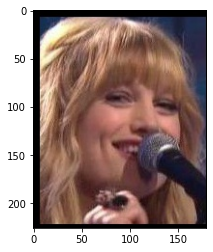

In [129]:
# source_state
image = cv2.imread(train_dataset.image_names[SAMPLE_N])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = image_with_landmarks(image, train_dataset.landmarks[SAMPLE_N].numpy())
_ = plt.imshow(image)

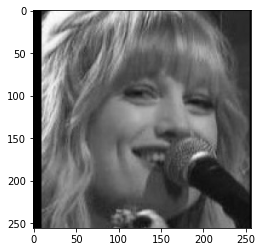

In [130]:
# transformed state
sample = train_dataset.__getitem__(SAMPLE_N)
#image = image_with_landmarks(sample['image'], sample['landmarks'].reshape(-1, 2).numpy())
_ = plt.imshow(sample['image'])

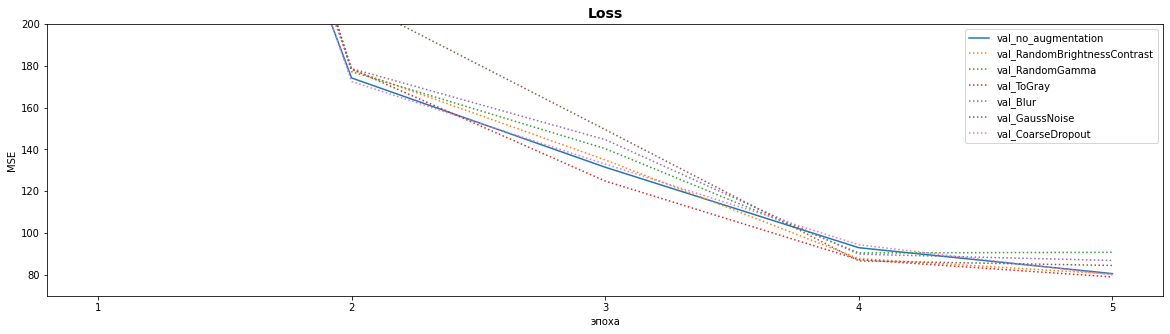

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:816: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)


In [59]:
# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes

for experiment in ['no_augmentation', 'RandomBrightnessContrast', 'RandomGamma', 'ToGray', 'Blur', 'GaussNoise', 'CoarseDropout']:
    
    with open(f'runs/{experiment}/metrics_{experiment}.txt') as f:
        metrics = json.load(f)

    # data
    x = range(1, len(metrics['val_loss']) + 1)
    ls = 'solid' if experiment=='no_augmentation' else 'dotted'
    ax.plot(x, metrics['val_loss'], linestyle=ls, label=f'val_{experiment}')

# annotation    
ax.set_title('Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('эпоха')
ax.set_ylabel('MSE')
ax.legend()
ax.set_xticks(range(1, len(metrics['train_loss']) + 1))
_ = ax.set_ylim([70, 200])